# P2 - Data Analysis

Written by Mahdi Naeini, Babak Hosseini Mohtasham, Parsa Ahmadi

In phase 2 of our DataScience project we tested different models and techniques to predict the phone prices we gathered in the previous phase.

# Imports

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_selection import mutual_info_regression

sns.set_theme()
random_state=42

# Part 1: Preprocessing

In [192]:
df = pd.read_csv('phones.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [193]:
df.head()

,Model,Release Data,Weight,Dimensions,Brand,Seller,Sim Card Description,Sim Card Type,Body Structure,Key Features,...,نارنجی,مشکی,آبی تیره,برنز,سبز تیره,ارغوانی,آبی یخی,آبی روشن,قهوه ای,Number of Availabler Colors
0,Redmi Note 13 4G,2024/1/15,188.5,8×75.6×162.3 میلی متر,Xiaomi,دیجی کالا,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,0,1,0,0,0,0,0,0,0,3
1,Redmi Note 13 4G,2024/1/15,188.5,8×75.6×162.3 میلی متر,Xiaomi,دیجی کالا,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,0,1,0,0,0,0,0,0,0,3
2,Redmi Note 13 4G,2024/1/15,188.5,8×75.6×162.3 میلی متر,Xiaomi,فیروزه همراه اسپادانا,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,0,1,0,0,0,0,0,0,0,3
3,Redmi Note 13 4G,2024/1/15,188.5,8×75.6×162.3 میلی متر,Xiaomi,اسمارت تکنولوژی قشم,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,0,1,0,0,0,0,0,0,0,3
4,Redmi Note 13 4G,2024/1/15,188.5,8×75.6×162.3 میلی متر,Xiaomi,اسمارت تکنولوژی قشم,سایز نانو (8.8 × 12.3 میلی متر),NaN,NaN,رابط کاربری MIUI 14,...,0,1,0,0,0,0,0,0,0,3


In [194]:
seller_one_hot = pd.get_dummies(df['Seller'], drop_first=False)
df=pd.concat([df,seller_one_hot],axis=1)
city_one_hot = pd.get_dummies(df['City'], drop_first=False)
df = pd.concat([df, city_one_hot], axis=1)

In [195]:
le = LabelEncoder()
df['Seller num'] = le.fit_transform(df['Seller'])
df['City num'] = le.fit_transform(df['City'])

In [196]:
df.loc[:, 'Category num'] = df['Category'].map({'اقتصادی دانش آموزی': 0, 'اقتصادی': 1, 'اقتصادی  میان رده': 2, ' میان رده': 3, 'گیمینگ  میان رده': 4, 'پرچم دار': 5})

In [197]:
df.loc[:,'Price No Discount']=df['Price No Discount']/1e6

In [198]:
def outlier_clean(df, column_list,thresh=1.5):
    for i in column_list:
        q1 = np.percentile(df[i], 25)
        q3 = np.percentile(df[i], 75)
        IQR = q3 - q1
        lower_bound = q1 - thresh * IQR
        upper_bound = q3 + thresh * IQR
        mask = (df[i] >= lower_bound) & (df[i] <= upper_bound)
        df = df[mask]
    return df

We had already done most of the preprocessings and feature engineerings in the previous phase so here we finished the rest of the preprocessing. We encoded the categorical features. Furthermore for easier understanding of price we divided the price by 1 million so now each price is in million tomans units. Moreover, we removed the outliers by finding the IQR but after changing our metric to mae we didn't use this function.

# Part 2: Feature Engineering and Selection

In [199]:
def extract_battery_capacity(x):
    if x == np.nan or type(x) != type(""):
        return np.nan
    ans=re.findall('\d* میلی آمپر|ظرفیت \d*',x)
    if not ans:
        return np.nan
    ans=re.sub('\D*','',ans[0])
    return ans

In [200]:
df.loc[:, 'Battery Capacity'] = df['Battery Spec'].apply(lambda x: extract_battery_capacity(x)).astype(float)

In [201]:
df['Battery Capacity'].isna().sum()

14

In [202]:
df[df.select_dtypes(include=[np.number, bool]).columns].corr()['Price No Discount'].sort_values(ascending=False).head(60)

Price No Discount               1.000000
Category num                    0.681333
X Screen Resolution             0.611054
Focus Technology Num            0.496993
طلایی                           0.476559
Pixel Density                   0.472461
Back Facing Cameras             0.442753
Internal Memory Num             0.440089
Weight                          0.424962
Cellular Network                0.406417
GPU Num                         0.374151
CPU Num                         0.357362
X Dimension                     0.345746
خاکستری                         0.342231
سفید                            0.268988
OS Num                          0.258495
سبز                             0.221300
Ratio of Screen Size to Body    0.221166
Number of Availabler Colors     0.197349
Range of Screen Size Min        0.188660
Range of Screen Size Max        0.188660
Screen Size                     0.186268
آبی روشن                        0.180907
Y Dimension                     0.176723
کرم             

In [203]:
df.select_dtypes(include=[np.number, bool]).isna().sum().sort_values(ascending=False).head(20)

Sim Card Type                   4126
GPU Num                          650
DAR                              480
CPU Clock Rate Min               398
CPU Clock Rate Max               398
Focus Technology Num             355
CPU Num                          347
OS Version Num                   317
RAM Num                          261
Release Data UNIX                255
OS Num                           230
Bluetooth Version                189
Ratio of Screen Size to Body     164
Score                            155
Camera Resolution                154
Category num                     147
SD Card Support Num              146
Internal Memory Num              113
Pixel Density                     60
Z Dimension                       55
dtype: int64

In [204]:
cols = df.select_dtypes(include=[np.number, bool]).columns.difference(['Price No Discount', 'Log Price No Discount', 'Sim Card Type'])

In [205]:
original_df=df.copy()

In [206]:
print(len(df))
df.dropna(subset=cols, inplace=True)
df.drop_duplicates(subset=cols.union(['Model']), inplace=True)
print(len(df))

4126
2514


# Part 3: Dimensionality Reduction

In [207]:
pca=PCA(n_components=2)
df_pca=pca.fit_transform(df[cols])
pca.explained_variance_ratio_

array([9.99975065e-01, 2.49299049e-05])

# Part 4: Evaluation Metric

In [208]:
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error

Our goal is to predict the price of mobile phones with as close as to actual value as possible so we decided to choose MAE as our primary metric. At first we chose RMSE but because RMSE is sensitive to outliers the model didn't perform that well and by removing outliers our model wouldn't have been trained on phones with prices greater than 30 million tomans and we know that these outliers are not due to random noise in our data so we've decided to change our loss function to mean absolute error which is robust to outliers but we've also reported RMSE and R2 score too. Furethermore, we have great number of features so we've decided to use adjusted R2 score as well to get a more accurate metric.

# Part 5: Model Training

In [209]:
X, y = df[cols], df['Price No Discount']
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

## Method One: Neural Network

In [80]:
from sklearn.neural_network import MLPRegressor

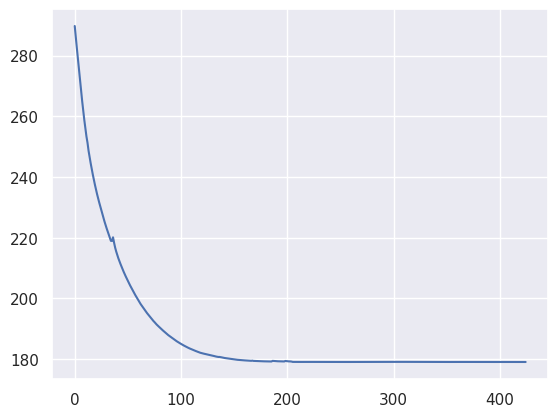

In [81]:
params = { 'hidden_layer_sizes' : [10,10],
           'activation': 'tanh', 'solver': 'adam',
    'random_state' : random_state,
    'learning_rate_init' : 0.001,
    'max_iter' : 1000, 'shuffle' : True,
    'n_iter_no_change' : 50, 'verbose' : False }
model=MLPRegressor(**params)
loss_list=model.fit(X_train,y_train)
plt.plot(loss_list.loss_curve_)

In [82]:
predictions=model.predict(X_test)
print(f'MAR: {mean_absolute_error(y_test,predictions)}')
print(f'RMSE: {root_mean_squared_error(y_test,predictions)}')
print(f'R2 Score: {r2_score(y_test,predictions)}')

MAR: 11.193949060262838
RMSE: 17.92002977183739
R2 Score: -6.49138784325487e-06


By testing different parameters of the neural network model, we've found out using relu doesn't give good results also we saw that the linear regression performs poorly too so it may be because our data is not linear.If we removed the outliers the neural networks rmse would have been around 6 million and other models would have been around 3 million. The performance of neural network and linear regression model has decreased without removing outliers. Though the overall performance and performance of other models have improved.

## Methods Two & Three

In [83]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy import stats

In [84]:
class MyRegressor:
    def __init__(self, model):
        self.model = model

    def tune_fit_predict_report(self, X_train, y_train, X_test, y_test, title=None, params=None):
        if params:
            self.tune_params(params, X_train, y_train)
        self.model.fit(X_train, y_train)
        predictions = self.model.predict(X_test)
        self.report(y_test, predictions, title)
    
    def report(self,y_test, predictions, title=None):
        mae = mean_absolute_error(y_test, predictions)
        rmse = root_mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test,predictions)
        adjusted_r2 = self.adjusted_r2(r2, df.shape[0], df.shape[1])
        print('\n')
        if title:
            print(title+':')
            print('######################################')
        print(f'MAE: {mae:.2f}')
        print('######################################')
        print(f'RMSE: {rmse:.2f}')
        print('######################################')
        print(f'R2 Score: {r2:.2f}')
        print('######################################')
        print(f'Adjusted R2 Score: {adjusted_r2:.2f}')
        self.plot_line(predictions,y_test,title)

    def tune_params(self, params, X_train, y_train):
        random_search = RandomizedSearchCV(self.model, param_distributions=params, n_iter=10,
                                           scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, random_state=random_state)
        random_search.fit(X_train, y_train)
        self.model=random_search.best_estimator_

    def adjusted_r2(self,r2,n,p):
        return 1-(1-r2)*(n-1)/(n-p-1)

    def plot_line(self, predicted_values, actual_values,title=None):
        plt.scatter(actual_values, predicted_values, color='blue')
        t = np.arange(min(actual_values), max(actual_values)+1,2)
        plt.plot(t, t, color='red')
        if title:
            plt.title(title)
        plt.show()

    def stratified_training(self, X_train, y_train, X_test, y_test, target_feature, title=None):
        fit_models = {}
        y_preds = []
        y_tests = []
        unique_models = X_train[target_feature].unique()
        for model in  unique_models:
            train_indices=X_train.index[X_train[target_feature] == model]
            _X_train = X_train.loc[train_indices].drop(columns=target_feature)
            _y_train = y_train.loc[train_indices]
            test_indices = X_test.index[X_test[target_feature] == model]
            if not len(test_indices):
                continue
            _X_test = X_test.loc[test_indices].drop(columns=target_feature)
            _y_test = y_test.loc[test_indices]
            fit_models[model] = self.model
            fit_models[model].fit(_X_train, _y_train)
            y_preds.extend(fit_models[model].predict(_X_test))
            y_tests.extend(_y_test)
        self.report(y_tests,y_preds,title)



Linear Regression Model:
######################################
MAE: 2100697.98
######################################
RMSE: 47111869.07
######################################
R2 Score: -6911718377771.62
######################################
Adjusted R2 Score: -8654284147155.25


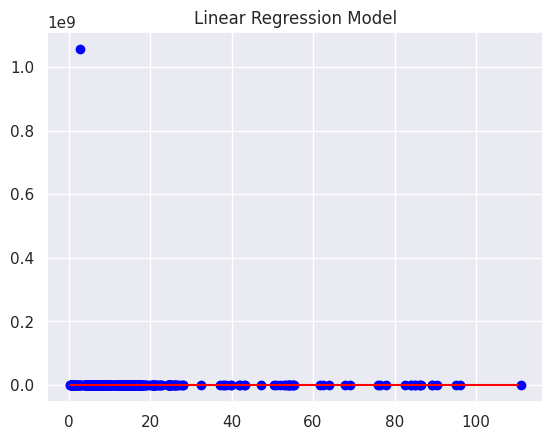

In [85]:
linear_regression_model=MyRegressor(LinearRegression())
linear_regression_model.tune_fit_predict_report(X_train, y_train,X_test,y_test,title='Linear Regression Model')

/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(




SVM Regression Model:
######################################
MAE: 10.04
######################################
RMSE: 18.39
######################################
R2 Score: -0.05
######################################
Adjusted R2 Score: -0.32


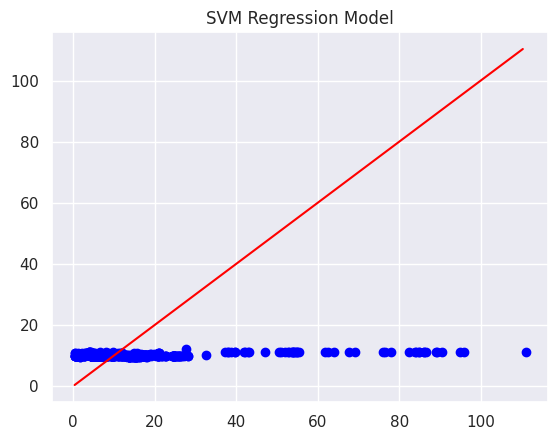

In [92]:
svm_model=MyRegressor(SVR())
params = {'kernel': ['poly', 'rbf', 'sigmoid']}
svm_model.tune_fit_predict_report(X_train, y_train, X_test,y_test,title='SVM Regression Model',params=params)



Ada Boost Regression Model:
######################################
MAE: 5.20
######################################
RMSE: 8.96
######################################
R2 Score: 0.75
######################################
Adjusted R2 Score: 0.69


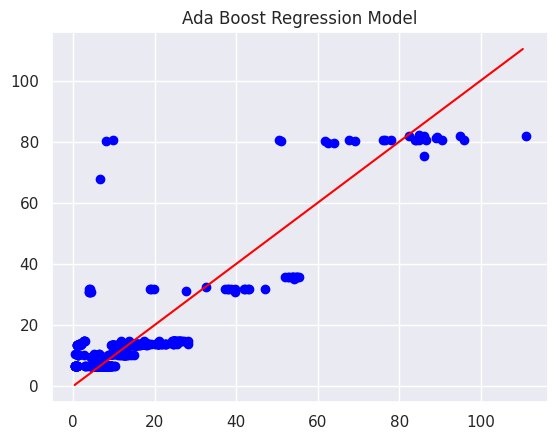

In [93]:
ada_boost_model = MyRegressor(AdaBoostRegressor())
params = {'random_state': [random_state], 'n_estimators': stats.randint(10, 200), 'learning_rate': stats.uniform(0, 0.1)}
ada_boost_model.tune_fit_predict_report(X_train, y_train, X_test, y_test, title='Ada Boost Regression Model',params=params)



Decision Tree Regression Model:
######################################
MAE: 3.28
######################################
RMSE: 8.86
######################################
R2 Score: 0.76
######################################
Adjusted R2 Score: 0.69


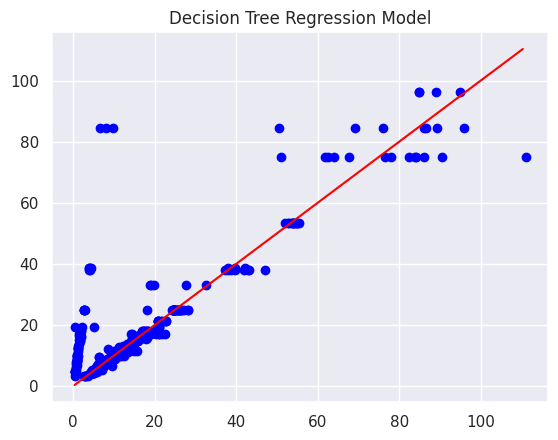

In [94]:
decision_tree_model = MyRegressor(DecisionTreeRegressor())
params = {'random_state': [random_state], 'criterion': ['absolute_error'], 'splitter': ['best', 'random'], 'max_features': stats.uniform(0, 1), 'max_depth': [
    None, 10, 100, 200], 'min_samples_split': stats.uniform(0, 1), 'min_samples_leaf': stats.uniform(0, 1)}
decision_tree_model.tune_fit_predict_report(X_train, y_train, X_test,y_test,title='Decision Tree Regression Model',params=params)



Random forest Regression Model:
######################################
MAE: 3.15
######################################
RMSE: 8.58
######################################
R2 Score: 0.77
######################################
Adjusted R2 Score: 0.71


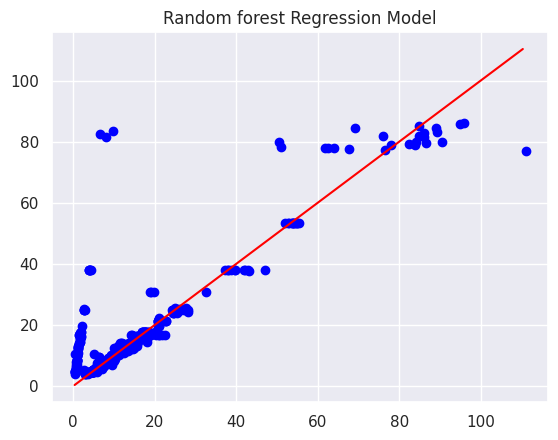

In [95]:
random_forest_model = MyRegressor(RandomForestRegressor())
params = {'random_state': [random_state], 'criterion': ['absolute_error'], 'n_estimators': stats.randint(10, 200), 'max_features': stats.uniform(0, 1), 'max_depth': [
    None, 10, 100, 200], 'min_samples_split': stats.uniform(0, 1), 'min_samples_leaf': stats.uniform(0, 1)}
random_forest_model.tune_fit_predict_report(X_train, y_train, X_test,y_test,title='Random forest Regression Model',params=params)



Cat Boost Regression Model:
######################################
MAE: 3.02
######################################
RMSE: 8.13
######################################
R2 Score: 0.79
######################################
Adjusted R2 Score: 0.74


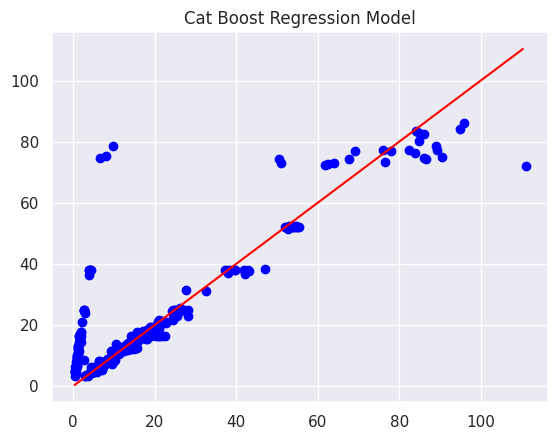

In [129]:
catboost_model = MyRegressor(CatBoostRegressor(silent=True))
params = {'n_estimators': stats.randint(10, 200), 'learning_rate': stats.uniform(
    0, 0.1), 'loss_function': ['MAE'], 'max_depth': [None, 6, 8, 10]}
catboost_model.tune_fit_predict_report(X_train, y_train, X_test, y_test,title='Cat Boost Regression Model',params=params)



XGB Boost Regression Model:
######################################
MAE: 3.90
######################################
RMSE: 7.75
######################################
R2 Score: 0.81
######################################
Adjusted R2 Score: 0.77


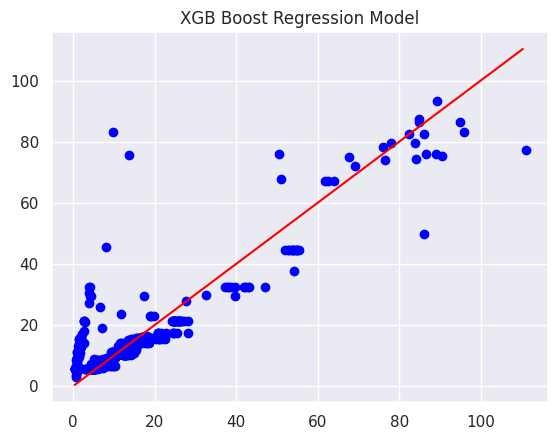

In [99]:
xgb_model = MyRegressor(XGBRegressor())
params = {'n_estimators': stats.randint(10, 200), 'booster': ["gbtree", "dart"], 'tree_method': ["auto", "exact", "approx", "hist"], 
          'learning_rate': stats.uniform(0, 0.1), 'eval_metric': ['mae'], 'max_depth': stats.randint(2, 50)}
xgb_model.tune_fit_predict_report(X_train, y_train, X_test, y_test, title='XGB Boost Regression Model', params=params)

/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/home/babak/Codes/Python/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric roge



KNN Regression Model:
######################################
MAE: 4.11
######################################
RMSE: 8.53
######################################
R2 Score: 0.77
######################################
Adjusted R2 Score: 0.72


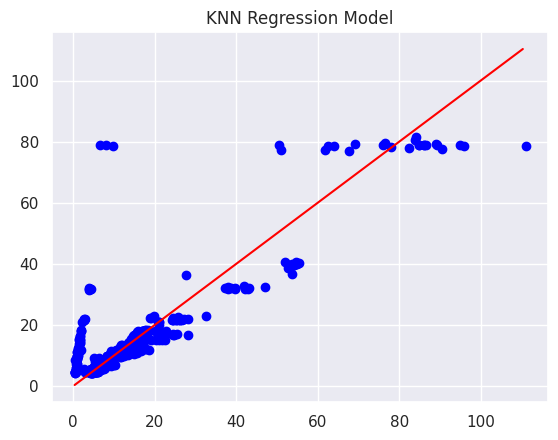

In [100]:
knn_model = MyRegressor(KNeighborsRegressor())
params = {'n_neighbors': np.arange(1, 100),
          'metric': ['russellrao', 'euclidean', 'l1', 'minkowski', 'hamming', 'dice',
                     'l2', 'p', 'infinity', 'sokalmichener', 'sokalsneath',
                     'rogerstanimoto', 'sqeuclidean', 'braycurtis', 'jaccard', 'correlation', 'cosine',
                     'nan_euclidean', 'manhattan', 'chebyshev', 'canberra', 'cityblock']}
knn_model.tune_fit_predict_report(X_train, y_train, X_test,y_test,title='KNN Regression Model', params=params)

We can see all the models have similar performance but catboost,xgb boost and random forest seem to have better results. We've also tested other models but their results were really bad so we removed them.

# Part 6: Feature Analysis

In [130]:
X, y = df_pca, df['Price No Discount']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

In [131]:
import plotly.express as px
px.scatter_3d(x=X_train[:,0],y=X_train[:,1],z=y_train)



Cat Boost Regression Model:
######################################
MAE: 3.84
######################################
RMSE: 8.86
######################################
R2 Score: 0.76
######################################
Adjusted R2 Score: 0.69


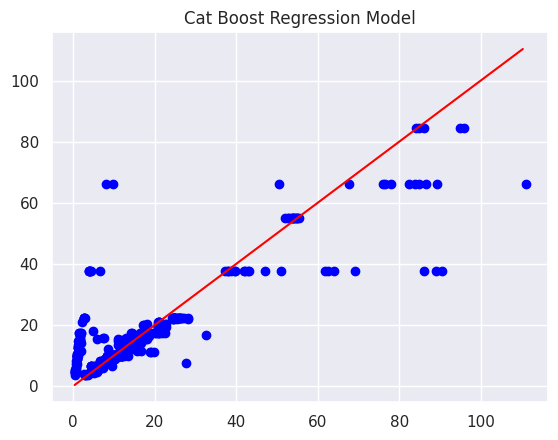

In [132]:
catboost_model.tune_fit_predict_report(X_train, y_train, X_test, y_test, title='Cat Boost Regression Model')

As we can see the loss didn't decrease so using PCA in this assignment doesn't seem to be that helpful.

# TODO

# Part 7: Overall Report and Discussions

This was one of the most challenging assignments of this semester. We were able to decrease the mae to 3.17 million tomans which fulfilled our goal. Here are some of the techniques we've tested in each part:
* **Preprocessing**: At first we were using RMSE as our metric so we removed outliers and this increased the performance a lot. But, removing outliers meant that our model could only predict prices below 30 million tomans so we changed our metric to MAE and we got better results. We've also used StandardScaler and PolynomialFeatures but they didn't improve the results.
* **Feature Engineering**: For categorical features we've tested both one hot encoding and label encoding. We've found out keeping both gives better results for city and seller.
* **Feature Selection**: Selecting a number of features and training the models using thoses improved the performance slightly. Though using PCA didn't perform that well.
* **Different Models**: We've trained many different models including: SVM, LinearRegression, LogisticRegression, DecisionTrees, RandomForest, NeuralNetworks, KNN, CatBoost, AdaBoost, GradientBoost, ....

By examining similar assignments like this one: https://www.kaggle.com/code/kishan9044/absolute-well-explained-linear-regression we can see that their best rmse was about 200 dollars which is about 14 million tomans so our model performs much better than using a dollar based model.

We thought the reason for not performing better may have been due to having mostly categorical features and also most of our sample data had common features and only differed in few features that were the seller and its city so we decided to use stratified training method. We also thought we may get better results if we use stratified sampling and training several models for different features.

# Part 8: Stratified Training

In [133]:
X, y = df[cols], df['Price No Discount']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)



Cat Boost Regression Model:
######################################
MAE: 2.95
######################################
RMSE: 7.94
######################################
R2 Score: 0.80
######################################
Adjusted R2 Score: 0.75


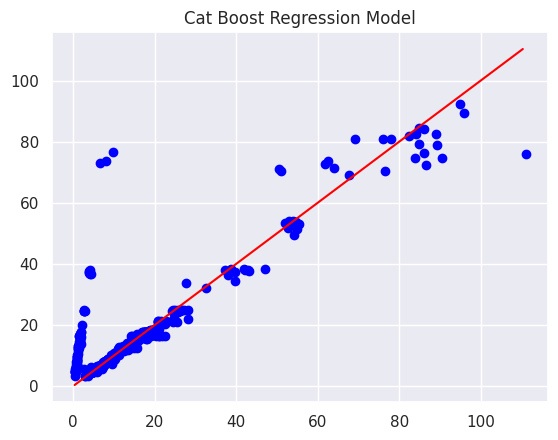

In [210]:
catboost_model.stratified_training(X_train, y_train, X_test, y_test, 'OS Num', title='Cat Boost Regression Model')



Cat Boost Regression Model:
######################################
MAE: 2.86
######################################
RMSE: 7.70
######################################
R2 Score: 0.82
######################################
Adjusted R2 Score: 0.77


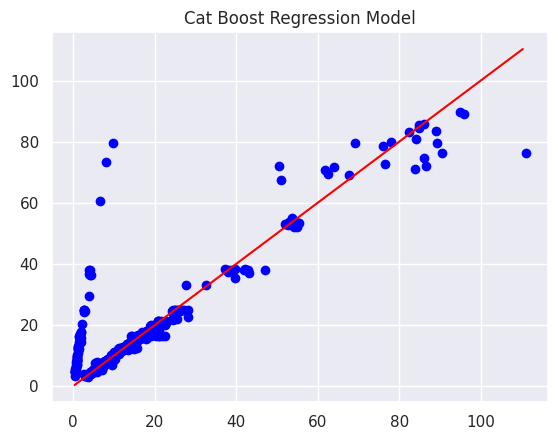

In [211]:
catboost_model.stratified_training(X_train, y_train, X_test, y_test, 'Category num', title='Cat Boost Regression Model')

# Part 9: Feature Reduction

To be fair we used too many features let'see but if we'd wish to use our model with other data these features may not be available so let's see if we'd be able to use less features while not increasing our loss that much.

In [214]:
importances = mutual_info_regression(df[cols], df['Price No Discount'])
feat_importances = pd.Series(importances, cols)
reduced_cols=feat_importances.sort_values(ascending=False).head(30)
reduced_cols

GPU Num                         1.752146
Weight                          1.750794
Ratio of Screen Size to Body    1.747270
Release Data UNIX               1.681619
CPU Num                         1.603061
Y Dimension                     1.568207
Z Dimension                     1.551636
Pixel Density                   1.443521
X Dimension                     1.230056
Screen Size                     1.166069
CPU Clock Rate Max              1.112026
Y Screen Resolution             0.967469
Display Technology Num          0.941867
CPU Clock Rate Min              0.848566
X Screen Resolution             0.841069
RAM Num                         0.759728
Score                           0.743674
Camera Resolution               0.692891
Battery Capacity                0.626351
Number of Availabler Colors     0.552249
Internal Memory Num             0.550095
Category num                    0.541025
Bluetooth Version               0.535252
Brand Founded Year              0.511232
Brand Num       

In [215]:
reduced_cols = reduced_cols.index.difference(['Score', 'GPU Num', 'CPU Num', 'Display Technology Num', 'Number of Availabler Colors', 'OS Version Num'])

In [216]:
less_feature_df = original_df.copy()

In [217]:
less_feature_df.dropna(subset=reduced_cols, inplace=True)
less_feature_df.drop_duplicates(subset=reduced_cols.union(['Model']), inplace=True)
len(less_feature_df)

156

In [218]:
X, y = less_feature_df[reduced_cols], less_feature_df['Price No Discount']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)



Cat Boost Regression Model:
######################################
MAE: 3.88
######################################
RMSE: 7.79
######################################
R2 Score: 0.93
######################################
Adjusted R2 Score: 0.92


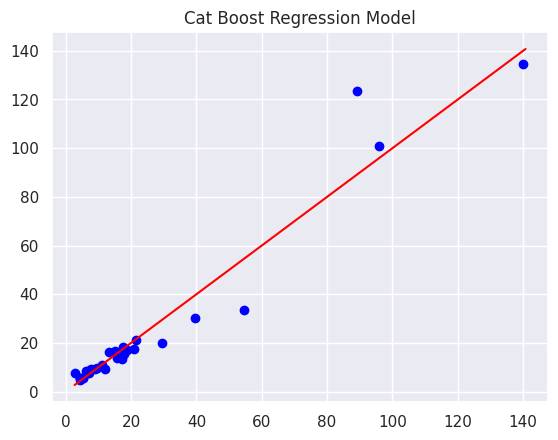

In [219]:
catboost_model.tune_fit_predict_report(X_train, y_train, X_test, y_test, title='Cat Boost Regression Model')

Well looks like our model performs okay with just the basic specs of a mobile phone and interestingly we are getting very high r2 score which means most of the price of a mobile phone can be described by its basic specs.